# WildFire ML Project - Convolutional Deep Neural Networks

### Import Modules

In [1]:
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from tqdm import tqdm
from sklearn import metrics
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

### Parameters Setup

In [3]:
batch_size = 20000 # 20000
split_ratio = 0.8
learning_rate = 0.00015
epochs = 250

### Load Dataset

In [4]:
# import dataset
dataset = pd.read_csv("modeling_cnn_data.csv")
print(dataset.columns)
# get x and y
x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x = np.array(x)
y = np.array(y).reshape(-1, 1)
print(x.shape, y.shape)

Index(['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness',
       'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m',
       'climate_rain', 'human_density', 'light_frequency', 'burned_area',
       'burned_area_mom', 'burned_area_yoy', 'month', 'sequence', 'lat', 'lon',
       'burned_area_mom_conv', 'burned_area_yoy_conv'],
      dtype='object')
(106863, 16) (106863, 1)


### Standardization / Normalization

In [5]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

### Train Test Split

In [6]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

### Define Dataset and Dataloader

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs).float()
        self.label = torch.tensor(data_targets).float()

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [8]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [9]:
for i,(v,j) in enumerate(TrainDataLoader):
    print(v.shape,j.shape)
    break

torch.Size([20000, 16]) torch.Size([20000, 1])


### Neural Network Architecture

In [10]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer5(x)
  
        return x

In [11]:
net = network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

network(
  (layer1): Linear(in_features=16, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Training

In [12]:
# metrics lists
train_loss_history = []
train_r2_history = []
val_loss_history = []
val_r2_history = []
val_rho_history = []

In [13]:
# Perform iterations
for epoch in tqdm(range(epochs), desc='Training'):
    # create lists
    train_loss_lst = []
    train_r2_lst = []
    val_loss_lst = []
    val_r2_lst = []
    val_rho_lst = []
    
    
    # ====== Training Mode ======
    net.train()
    for (x_input, y_true) in TrainDataLoader:
        # attach to GPU
        x_input = x_input.to(device)
        y_true = y_true.to(device)
        # gain outputs
        outputs = net(x_input)
        # compute loss
        loss = criterion(outputs, y_true)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # r2 = r_squared(y_true, outputs)
        r2 = metrics.r2_score(y_true.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        # append results
        train_loss_lst.append(loss.item())
        train_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = train_r2_lst.index(max(train_r2_lst))
    train_loss_history.append(train_loss_lst[best_perform])
    train_r2_history.append(train_r2_lst[best_perform])
    # ====== Training Mode End ======
    
    
    # ====== Testing Mode ======
    net.eval()
    for (x_val_input, y_val_input) in TestDataLoader:
        # attach to GPU
        x_val_input = x_val_input.to(device)
        y_val_input = y_val_input.to(device)
        # gain outputs
        outputs = net(x_val_input)
        # compute loss
        loss = criterion(outputs, y_val_input)
        # r2 = r_squared(y_val_input, outputs) & Rho
        r2 = metrics.r2_score(y_val_input.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        rho = np.corrcoef(y_val_input.detach().cpu().numpy().squeeze(), outputs.detach().cpu().numpy().squeeze())[0][1]
        # append results
        val_rho_lst.append(rho)
        val_loss_lst.append(loss.item())
        val_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = val_r2_lst.index(max(val_r2_lst))
    val_loss_history.append(val_loss_lst[best_perform])
    val_r2_history.append(val_r2_lst[best_perform])
    val_rho_history.append(val_rho_lst[best_perform])
    # ====== Testing Mode End ======
    
    
    # output the performance every 10 times
    if str(epoch+1).endswith("0"):
        print("Current Epoch: "+str(epoch+1)+"/"+str(epochs), " | Train Loss: "+str(train_loss_history[-1]), " | Train R2: "+str(train_r2_history[-1])," | Val Loss: "+str(val_loss_history[-1])," | Val Rho: "+str(val_rho_history[-1])," | Val R2: "+str(val_r2_history[-1]))

Training:   4%|▍         | 10/250 [00:14<04:22,  1.09s/it]

Current Epoch: 10/250  | Train Loss: 0.971619188785553  | Train R2: 0.03263999547209717  | Val Loss: 0.5053271055221558  | Val Rho: 0.7948377545728991  | Val R2: 0.05779774751996003


Training:   8%|▊         | 20/250 [00:24<03:57,  1.03s/it]

Current Epoch: 20/250  | Train Loss: 0.7829652428627014  | Train R2: 0.24496220338776964  | Val Loss: 0.3763584494590759  | Val Rho: 0.8589360657851901  | Val R2: 0.29826489067755024


Training:  12%|█▏        | 30/250 [00:35<03:51,  1.05s/it]

Current Epoch: 30/250  | Train Loss: 0.6006632447242737  | Train R2: 0.41698242471646774  | Val Loss: 0.26876479387283325  | Val Rho: 0.855965272538178  | Val R2: 0.49887743014342767


Training:  16%|█▌        | 40/250 [00:45<03:32,  1.01s/it]

Current Epoch: 40/250  | Train Loss: 0.49887144565582275  | Train R2: 0.5214293549638951  | Val Loss: 0.21650980412960052  | Val Rho: 0.8469044010451113  | Val R2: 0.5963089209750461


Training:  20%|██        | 50/250 [00:55<03:18,  1.01it/s]

Current Epoch: 50/250  | Train Loss: 0.42764046788215637  | Train R2: 0.5860039660505334  | Val Loss: 0.19257578253746033  | Val Rho: 0.8406117985096276  | Val R2: 0.6409348746796182


Training:  24%|██▍       | 60/250 [01:05<03:09,  1.00it/s]

Current Epoch: 60/250  | Train Loss: 0.38133499026298523  | Train R2: 0.6258631239207099  | Val Loss: 0.18175792694091797  | Val Rho: 0.8366438133012724  | Val R2: 0.6611051663829413


Training:  28%|██▊       | 70/250 [01:15<03:00,  1.00s/it]

Current Epoch: 70/250  | Train Loss: 0.3538989722728729  | Train R2: 0.6561548094168401  | Val Loss: 0.17720066010951996  | Val Rho: 0.8351792472772666  | Val R2: 0.6696023956860517


Training:  32%|███▏      | 80/250 [01:26<03:04,  1.09s/it]

Current Epoch: 80/250  | Train Loss: 0.3453601598739624  | Train R2: 0.6672905988492739  | Val Loss: 0.17398706078529358  | Val Rho: 0.8365825058408444  | Val R2: 0.6755942703164237


Training:  36%|███▌      | 90/250 [01:36<02:45,  1.04s/it]

Current Epoch: 90/250  | Train Loss: 0.3275330364704132  | Train R2: 0.678318761927605  | Val Loss: 0.1698329597711563  | Val Rho: 0.8398984702479001  | Val R2: 0.6833397532058942


Training:  40%|████      | 100/250 [01:46<02:29,  1.00it/s]

Current Epoch: 100/250  | Train Loss: 0.32811394333839417  | Train R2: 0.6821739034760729  | Val Loss: 0.16493219137191772  | Val Rho: 0.8438928307313562  | Val R2: 0.6924774241311513


Training:  44%|████▍     | 110/250 [01:56<02:27,  1.05s/it]

Current Epoch: 110/250  | Train Loss: 0.3214971721172333  | Train R2: 0.6878082183176775  | Val Loss: 0.16042158007621765  | Val Rho: 0.847693966950048  | Val R2: 0.7008876335785669


Training:  48%|████▊     | 120/250 [02:07<02:11,  1.01s/it]

Current Epoch: 120/250  | Train Loss: 0.3178524374961853  | Train R2: 0.692197536855925  | Val Loss: 0.15565019845962524  | Val Rho: 0.8513053746964864  | Val R2: 0.7097840779318789


Training:  52%|█████▏    | 130/250 [02:17<02:02,  1.02s/it]

Current Epoch: 130/250  | Train Loss: 0.3101574182510376  | Train R2: 0.6954614447174012  | Val Loss: 0.152727872133255  | Val Rho: 0.8537925683463221  | Val R2: 0.7152328520157647


Training:  56%|█████▌    | 140/250 [02:27<01:54,  1.05s/it]

Current Epoch: 140/250  | Train Loss: 0.30741655826568604  | Train R2: 0.7030874027901503  | Val Loss: 0.14995260536670685  | Val Rho: 0.85604627910295  | Val R2: 0.7204074664791449


Training:  60%|██████    | 150/250 [02:38<01:42,  1.03s/it]

Current Epoch: 150/250  | Train Loss: 0.3079392611980438  | Train R2: 0.7038945224896846  | Val Loss: 0.147367462515831  | Val Rho: 0.8578634626497461  | Val R2: 0.7252275544921881


Training:  64%|██████▍   | 160/250 [02:48<01:33,  1.04s/it]

Current Epoch: 160/250  | Train Loss: 0.2940215766429901  | Train R2: 0.7147149250928875  | Val Loss: 0.1457156389951706  | Val Rho: 0.8592786260378045  | Val R2: 0.7283074630844439


Training:  68%|██████▊   | 170/250 [02:58<01:21,  1.02s/it]

Current Epoch: 170/250  | Train Loss: 0.27990472316741943  | Train R2: 0.721086678732184  | Val Loss: 0.14478810131549835  | Val Rho: 0.8601836914332339  | Val R2: 0.7300368558889134


Training:  72%|███████▏  | 180/250 [03:09<01:13,  1.05s/it]

Current Epoch: 180/250  | Train Loss: 0.2965271770954132  | Train R2: 0.7121560087919456  | Val Loss: 0.143320232629776  | Val Rho: 0.8612994361702061  | Val R2: 0.7327737696462069


Training:  76%|███████▌  | 190/250 [03:19<01:04,  1.08s/it]

Current Epoch: 190/250  | Train Loss: 0.29527953267097473  | Train R2: 0.7131056782439369  | Val Loss: 0.14246684312820435  | Val Rho: 0.8620948793960559  | Val R2: 0.7343649746270238


Training:  80%|████████  | 200/250 [03:29<00:47,  1.05it/s]

Current Epoch: 200/250  | Train Loss: 0.28935015201568604  | Train R2: 0.7150105766777386  | Val Loss: 0.14180493354797363  | Val Rho: 0.8630016773241219  | Val R2: 0.7355991224982027


Training:  84%|████████▍ | 210/250 [03:39<00:40,  1.00s/it]

Current Epoch: 210/250  | Train Loss: 0.2852395474910736  | Train R2: 0.7205813183861436  | Val Loss: 0.14046581089496613  | Val Rho: 0.8641116019270924  | Val R2: 0.7380959470136523


Training:  88%|████████▊ | 220/250 [03:49<00:28,  1.05it/s]

Current Epoch: 220/250  | Train Loss: 0.2712835669517517  | Train R2: 0.7298702826243733  | Val Loss: 0.13956166803836823  | Val Rho: 0.8649682808807652  | Val R2: 0.7397817579167433


Training:  92%|█████████▏| 230/250 [03:59<00:19,  1.03it/s]

Current Epoch: 230/250  | Train Loss: 0.28732460737228394  | Train R2: 0.7211041956821451  | Val Loss: 0.1380382478237152  | Val Rho: 0.8662775851656059  | Val R2: 0.7426222494344055


Training:  96%|█████████▌| 240/250 [04:09<00:10,  1.01s/it]

Current Epoch: 240/250  | Train Loss: 0.27680253982543945  | Train R2: 0.7367880656712729  | Val Loss: 0.1376217007637024  | Val Rho: 0.8667774219484651  | Val R2: 0.7433989318534906


Training: 100%|██████████| 250/250 [04:19<00:00,  1.04s/it]

Current Epoch: 250/250  | Train Loss: 0.2816678583621979  | Train R2: 0.7251970538171606  | Val Loss: 0.13687090575695038  | Val Rho: 0.8675893230733182  | Val R2: 0.7447988104750058


### Save model parameters

In [14]:
# Save Model Path
path = "WildFire CNN Prediction.pth"
torch.save(net.state_dict(),path)
print("Model saved to local disk.")

evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy","validation Rho"])
evaluation["train loss"] =train_loss_history
evaluation["train accuracy"] =train_r2_history
evaluation["validation loss"] =val_loss_history
evaluation["validation accuracy"] = val_r2_history
evaluation["validation Rho"] = val_rho_history
evaluation.to_csv("model_cnn_evaluation.csv",index=False)
print("Evaluation Metrics saved to local disk.")

Model saved to local disk.
Evaluation Metrics saved to local disk.


### Model Performance Check

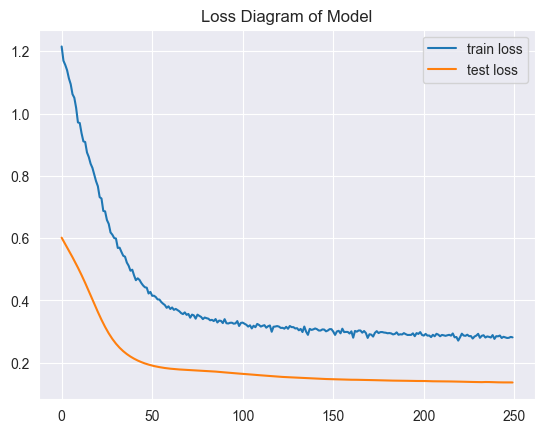

In [15]:
plt.plot(train_loss_history, label = "train loss")
plt.plot(val_loss_history, label = "test loss")
plt.title("Loss Diagram of Model")
plt.legend()

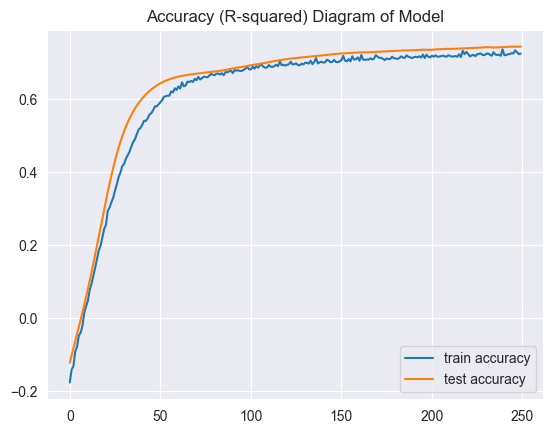

In [16]:
plt.plot(train_r2_history, label = "train accuracy")
plt.plot(val_r2_history, label = "test accuracy")
plt.title("Accuracy (R-squared) Diagram of Model")
plt.legend()

Text(0.5, 1.0, 'Correlation between prediction & true burned area')

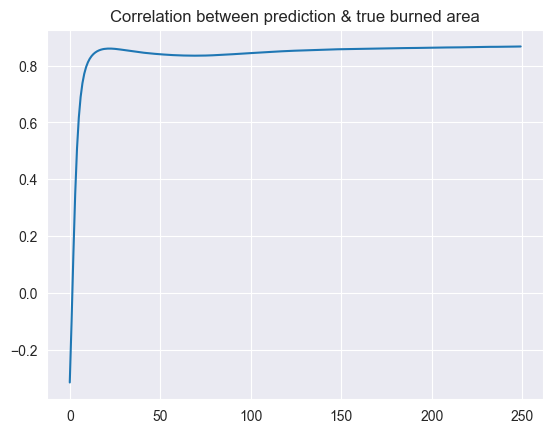

In [17]:
plt.plot(val_rho_history)
plt.title("Correlation between prediction & true burned area")